In [4]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

### Ball, Players, Goalkeepers, and Referees Detection

In [5]:
from ultralytics import YOLO

PLAYER_DETECTION_MODEL = YOLO('../models/detection_model/weights/best_detection.pt')


##### Single Frame Detection

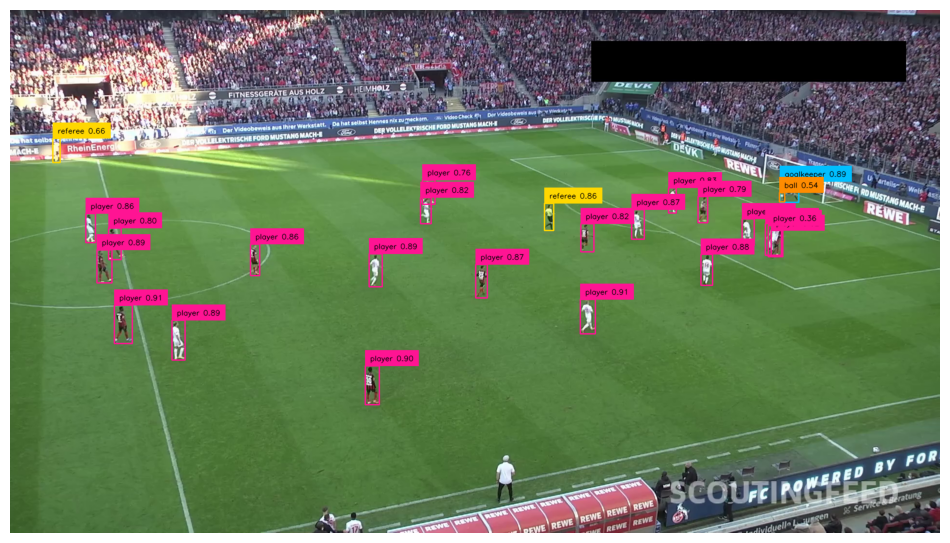

In [18]:
import supervision as sv

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000")
)

SOURCE_VIDEO_PATH = "../content/573e61_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator) # get a single frame; frame is HxWx3 NumPy array in BGR

# get detections for first image (theres only one image rn)
# results holds: Bounding Boxes ([x1, y1, x2, y2]), confidence scores, class ids
result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3, verbose=False)[0] 

# convert to sv.Detections object
# array of box coordinates, array of scores, array of class indices
detections = sv.Detections.from_ultralytics(result) 

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections["class_name"], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(annotated_frame, detections) # draws detections info on frame
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)

sv.plot_image(annotated_frame)

### Video Detection

In [ ]:
import supervision as sv
from tqdm import tqdm

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000")
)

SOURCE_VIDEO_PATH = "../content/121364_0.mp4"
TARGET_VIDEO_PATH = "../content/121364_0_result_1.mp4"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)            # includes resolution, fps, frame count, etc
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)     # manages writing annotated frames to the output video

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)      # gets each frame one at at time

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # get detections for first image (theres only one image rn)
        # results holds: Bounding Boxes ([x1, y1, x2, y2]), confidence scores, class ids
        result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3, verbose=False)[0] 

        # convert to sv.Detections object
        # array of box coordinates, array of scores, array of class indices
        detections = sv.Detections.from_ultralytics(result) 

        labels = [
            f"{class_name} {confidence:.2f}"
            for class_name, confidence
            in zip(detections["class_name"], detections.confidence)
        ]

        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate(annotated_frame, detections) # draws detections info on frame
        annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)
        video_sink.write_frame(annotated_frame)     # writes frame to output video


100%|██████████| 750/750 [00:19<00:00, 39.09it/s]


### Video Detection - Advanced

In [17]:
import supervision as sv
from tqdm import tqdm

SOURCE_VIDEO_PATH = "../content/121364_0.mp4"
TARGET_VIDEO_PATH = "../content/121364_0_result_1.mp4"
BALL_ID = 0

# draw ellipse over players and referees
elipse_annotator = sv.EllipseAnnotator(                                       
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

# labels below players, display their tracker id
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER
)

# draw triangle above ball
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex("FFD700"),
    base = 20, height=17
)

tracker = sv.ByteTrack()    # object tracker
tracker.reset()


video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)            # includes resolution, fps, frame count, etc
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)     # manages writing annotated frames to the output video

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)      # gets each frame one at at time

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # get detections for first image (theres only one image rn)
        # results holds: Bounding Boxes ([x1, y1, x2, y2]), confidence scores, class ids
        result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3, verbose=False)[0] 

        # convert to sv.Detections object
        # array of box coordinates, array of scores, array of class indices
        detections = sv.Detections.from_ultralytics(result) 

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)   # move triangle 10 pixels above the ball

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)    # remove duplicate boxes
        all_detections.class_id = all_detections.class_id - 1
        all_detections = tracker.update_with_detections(all_detections)                 # assigns and maintains a tracker_id for each object across frames

        labels = [
            f"#{tracker_id}" for tracker_id in all_detections.tracker_id
        ]        

        annotated_frame = frame.copy()
        annotated_frame = elipse_annotator.annotate(annotated_frame, all_detections)                    # draws elipses on players
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)                 # draws triangle above ball
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)      # draws tracker ids

        video_sink.write_frame(annotated_frame)                                                         # writes frame to output video



100%|██████████| 750/750 [00:20<00:00, 35.88it/s]


### Team Clustering by Player

In [ ]:
from tqdm import tqdm

STRIDE = 30         # process 1 in every 30 frames
PLAYER_ID = 2       # only extract crops of class_id = 2 (players)

def extract_crops(source_video_path: str):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)   # load every 30th frame from the video

    crops = [] 
    
    # iterate over sampled frames; tqdm just gives progress bar in terminal
    for frame in tqdm(frame_generator, desc="Collecting crops"):                    
        result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops += [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    return crops



In [23]:
crops = extract_crops(SOURCE_VIDEO_PATH)

In [19]:
len(crops)

496

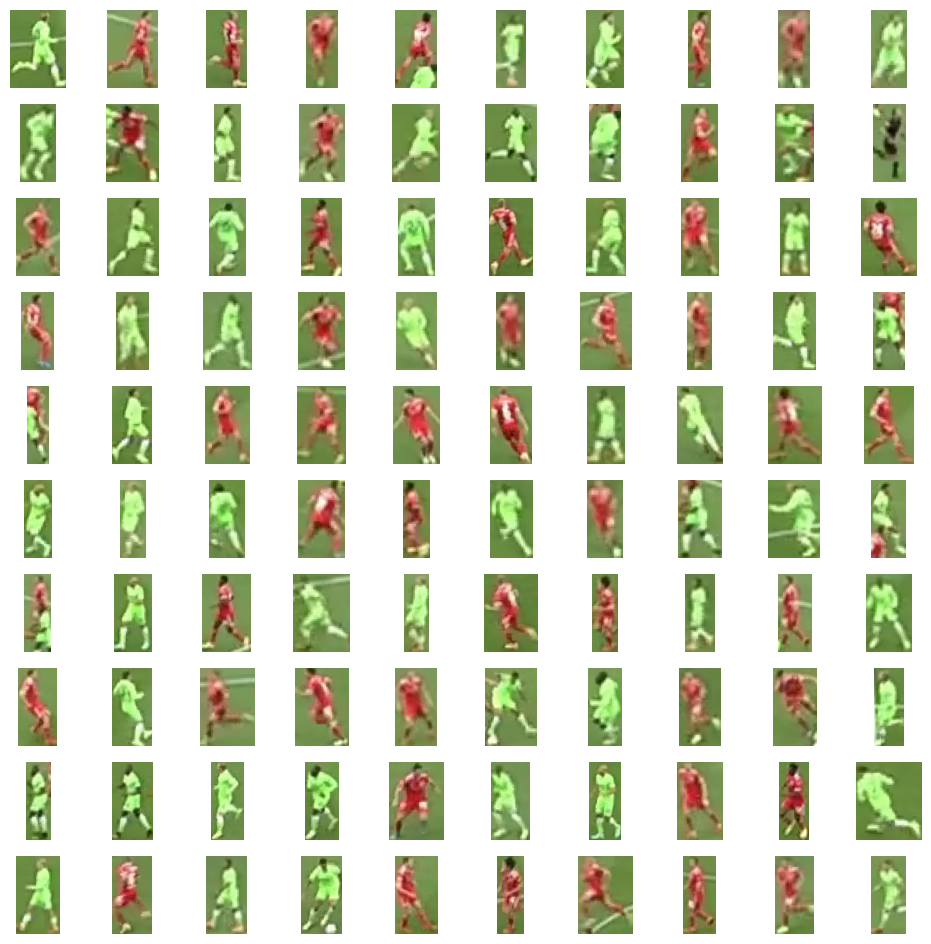

In [20]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [ ]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

# huggingface SigLIP model
# trained for vision language embedding
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# load visiaon only part of SigLIP; move model to CPU or GPU
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)

# handle all preprocessing automatically
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [24]:
import numpy as np

from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]      # converts each crop from cv2 format to PIL.image (pillow)
batches = chunked(crops, BATCH_SIZE)                    # breaks list into chunks of 32 crops per batch
data = []

with torch.no_grad():   # no gradient computation needed
    for batch in tqdm(batches, desc='embeddings extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors='pt').to(DEVICE)         # preprocess each image and convert to PyTorch tensor; move tensors to GPU
        outputs = EMBEDDINGS_MODEL(**inputs)                                                # run inference on tensors using SigLIP model
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()             # get a single embedding tensor per image -> convert to numpy array
        data.append(embeddings)

# data is numpy array of shape [len(crops), hidden_dim]
# each row is an embedding representing a crop
data = np.concatenate(data)



embeddings extraction: 16it [00:03,  4.87it/s]


In [ ]:
data.shape      # 496 embeddings for 496 crops

(496, 768)

In [ ]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)         # used to project high dimensional data (768-Dim SigLIP embeddings) into 3 dimensions
CLUSTERING_MODEL = KMeans(n_clusters=2)     # creates KMeans clustering model that will partition embeddings into two clusters


In [27]:
projections = REDUCER.fit_transform(data)   # applies UMAP to image embeddings and returns a lower dimensional projection (3 dimensions)
projections.shape

(496, 3)

In [28]:
clusters = CLUSTERING_MODEL.fit_predict(projections)    # runs clustering model on 3 dimensional embeddings; clusters each crop into one of two clusters

In [29]:
clusters[:10]

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 0], dtype=int32)

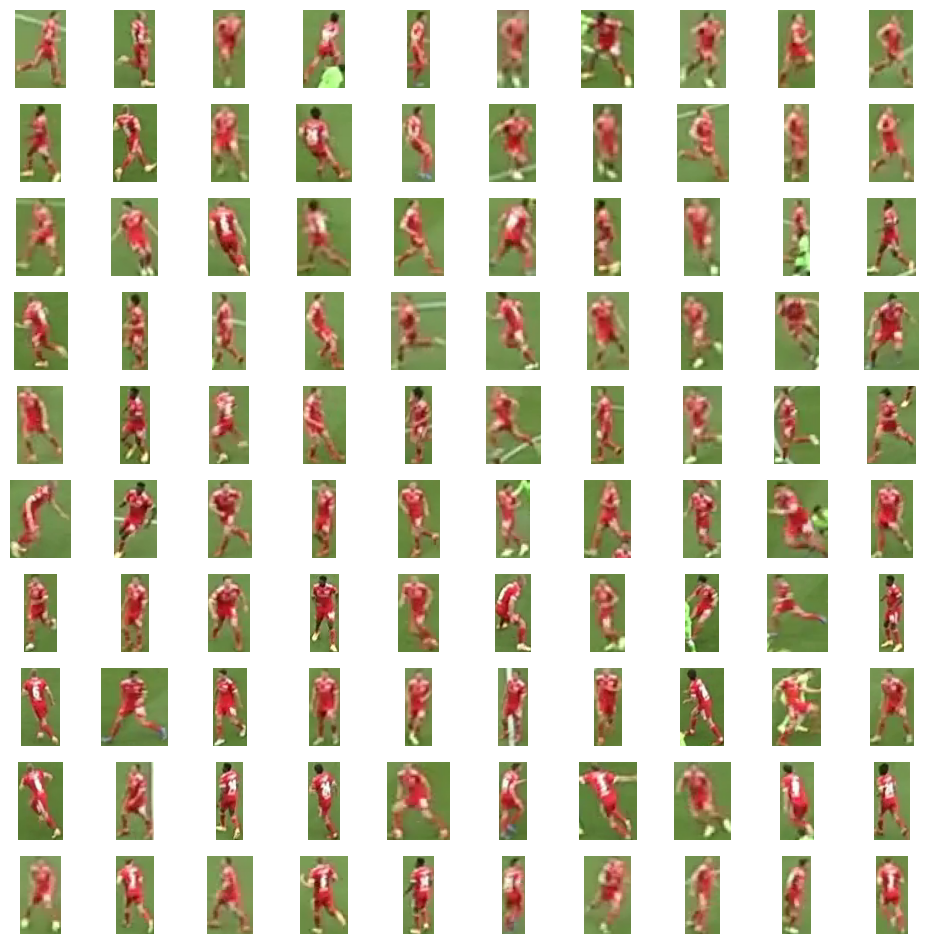

In [31]:
team_0 = []
team_1 = []

for crop, cluster in zip(crops, clusters):
    if cluster == 0:
        team_0.append(crop)
    else:
        team_1.append(crop)

sv.plot_images_grid(team_1[:100], grid_size=(10, 10))

### Plug Team Clustering into Video Tracking

In [35]:
def resolve_goalkeepers_team_id(players_detections: sv.Detections, goalkeepers_detections: sv.Detections):
    """
    Method to determine which goalkeeper belongs to which team. Goalkeeper is assigned to the team
    whose team centroid is closest to him. 
    """
    goalkeepers_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    team_0_centroid = players_xy[players_detections.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players_detections.class_id == 1].mean(axis=0)

    goalkeepers_team_ids = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_ids.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_ids)

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "../content/121364_0.mp4"
TARGET_VIDEO_PATH = "../content/121364_0_result_1.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFERREE_ID = 3

# === SET UP TEAM CLASSIFIER
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)      # train a lightweight team classifier to separate teams


# === SET UP ANNOTATORS === 

# draw ellipse over players and referees
elipse_annotator = sv.EllipseAnnotator(                                       
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

# labels below players, display their tracker id
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER
)

# draw triangle above ball
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex("FFD700"),
    base = 20, height=17
)

# === OBJECT TRACKER FOR IDS ===
tracker = sv.ByteTrack()    # object tracker
tracker.reset()


video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)            # includes resolution, fps, frame count, etc
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)     # manages writing annotated frames to the output video

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)      # gets each frame one at at time


# === ITERATE THROUGH FRAMES ===
with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # get detections for first image (theres only one image rn)
        # results holds: Bounding Boxes ([x1, y1, x2, y2]), confidence scores, class ids
        result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3, verbose=False)[0] 

        # convert to sv.Detections object
        # array of box coordinates, array of scores, array of class indices
        detections = sv.Detections.from_ultralytics(result) 

        # Get ball detections
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)   # move triangle 10 pixels above the ball


        # Get detections besides ball 
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)    # remove duplicate boxes
        all_detections = tracker.update_with_detections(all_detections)                 # assigns and maintains a tracker_id for each object across frames


        # Get player, goalkeeper, and referee detections individually
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referees_detection = all_detections[all_detections.class_id == REFERREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]    # extract player crops from frame
        players_detections.class_id = team_classifier.predict(players_crops).astype(int)    # overwrite class_id with team id from classifier model

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(                      # assign goalkeepers to a team
            players_detections, goalkeepers_detections
        ).astype(int)

        referees_detection.class_id -= 1

        all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detection])

        # add labels to each detection
        labels = [
            f"#{tracker_id}" for tracker_id in all_detections.tracker_id
        ]        


        # Draw detection data to frame
        annotated_frame = frame.copy()
        annotated_frame = elipse_annotator.annotate(annotated_frame, all_detections)                    # draws elipses on players
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)                 # draws triangle above ball
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)      # draws tracker ids

        video_sink.write_frame(annotated_frame)                                                         # writes frame to output video



Embedding extraction: 16it [00:03,  5.25it/s]
Embedding extraction: 1it [00:00,  7.56it/s]
Embedding extraction: 1it [00:00,  7.57it/s]/s]
Embedding extraction: 1it [00:00,  7.93it/s]/s]
Embedding extraction: 1it [00:00,  8.37it/s]/s]
Embedding extraction: 1it [00:00,  8.00it/s]/s]
Embedding extraction: 1it [00:00,  8.35it/s]/s]
Embedding extraction: 1it [00:00,  8.90it/s]/s]
Embedding extraction: 1it [00:00,  8.35it/s]/s]
Embedding extraction: 1it [00:00,  7.94it/s]/s]
Embedding extraction: 1it [00:00,  8.00it/s]/s]
Embedding extraction: 1it [00:00,  7.61it/s]t/s]
Embedding extraction: 1it [00:00,  7.60it/s]t/s]
Embedding extraction: 1it [00:00,  7.95it/s]t/s]
Embedding extraction: 1it [00:00,  7.98it/s]t/s]
Embedding extraction: 1it [00:00,  7.97it/s]t/s]
Embedding extraction: 1it [00:00,  7.96it/s]t/s]
Embedding extraction: 1it [00:00,  8.02it/s]t/s]
Embedding extraction: 1it [00:00,  7.96it/s]t/s]
Embedding extraction: 1it [00:00,  7.98it/s]t/s]
Embedding extraction: 1it [00:00,  7